## Part 2 - Predicting Bad Loans vs Good Loans

There is plenty of different machine learning problems we could tackle with this [lending club dataset](https://www.kaggle.com/wendykan/lending-club-loan-data).

I do plan on doing more than just one machine learning problem. However, for the first one my goal is to figure out how to predict **bad debt vs good debt**. This is a **classic classification problem**, and I will use various classification models to tackle this problem.

**Target Variable:** loan_status

In [15]:
#importing the holy trinity of data science plugins
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt 

#Importing

import warnings
warnings.filterwarnings("ignore")

#Sklearn Plugins
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn import preprocessing
from sklearn.decomposition import PCA

### Step 1: Data Cleaning

I will do some light data cleaning, at some point I will just make a python script once I start having more notebooks with different problems to tackle. For now It will be located in this notebook. 

In [2]:
df = pd.read_csv('/Users/andrewberry/Downloads/lending-club-loan-data/loan.csv', low_memory=False)

In [3]:
# Removing columns that represent information that is not necessary or 
# information available to lender prior to lending the loan
df = df.drop(['total_pymnt_inv','total_pymnt',
              'debt_settlement_flag','out_prncp',
              'last_pymnt_d','last_pymnt_amnt',
              'out_prncp_inv','total_rec_int',
              'total_rec_late_fee','recoveries',
              'collection_recovery_fee','total_rec_prncp',
              'total_rev_hi_lim','total_rec_int']
             ,axis = 1)

In [4]:
#Dropping features with 30% or more missing data
df.dropna(thresh = 0.7*(len(df)), axis = 1, inplace = True)

In [5]:
#New Column representing year
df['year'] = pd.to_datetime(df.issue_d).dt.year

For the step above of creating the year column. I am not sure if creating it adds much value if I am planning one hot encode the *issue_d* variable. 

In [6]:
#Modified Code Below taken from https://www.kaggle.com/janiobachmann/lending-club-risk-analysis-and-metrics/notebook
#Determining the loans that are bad from loan_status column
#I want to convert the loan status to binary 

bad_loan = ["Charged Off", "Default", 
            "Does not meet the credit policy. Status:Charged Off", 
            "In Grace Period", 
            "Late (16-30 days)", 
            "Late (31-120 days)"]

def loan_condition(status):
    if status in bad_loan:
        return 0 #bad loan
    else:
        return 1 #good loan
    
df['loan_status'] = df['loan_status'].apply(loan_condition)

After doing this step, there is still a lot of rows with missing values in various places. I have around 2 million rows, I tried the following code: 

``` python
df.dropna(axis =0, how = 'any')
```

However, it reduces the amount of rows to 1,650,000~ roughly. 

I will however, attempt to fill missing data with the mean to preserve much of the dataset. 

In [7]:
#df = df.fillna(df.mean(), inplace=True)

The code above took too long for my machine to process, so I will just do my original method. Dang it! :( 

In [8]:
df = df.dropna(axis =0, how = 'any')
#save that, so I don't have to process again. 
df.to_csv('data/loan_no_nans.csv')

In [9]:
df.shape

(1654008, 75)

## Baseline Model - Logistic Regression (No Scaling, No Feature Selection, etc)

I want to fit a quick baseline model to this data using logistic regression with optimization of the c perameter. 

I do plan on trying these preprocessing methods and models:
- Scaling (Standard Scaling, Min Max Scaler)
- PCA
- OverSampling Target Variable
- Decision Trees
- Random Forest
- Neurel Networks

In [5]:
df_clean = pd.read_csv('data/loan_no_nans.csv',index_col=0,
                      low_memory = False)


In [6]:
#Will use a 20% subset of the dataset, in order to reduce computational time
df_clean = df_clean.sample(frac = 0.05, 
                          random_state = 42)
#target variable
df_clean['loan_status'].value_counts()

1    71885
0    10815
Name: loan_status, dtype: int64

In [7]:
df_clean.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,year
1204665,12000,12000,12000.0,36 months,15.61,419.58,D,D1,Analyst,1 year,MORTGAGE,56000.0,Source Verified,May-2015,1,n,debt_consolidation,Debt consolidation,191xx,PA,22.03,0.0,Feb-2005,1.0,15.0,0.0,6544,35.6,24.0,f,Feb-2019,0.0,1,Individual,0.0,0.0,144804.0,9.0,10343.0,4768.0,51.3,0.0,0.0,37.0,82.0,4.0,4.0,4.0,4.0,4.0,0.0,2.0,7.0,3.0,3.0,7.0,10.0,13.0,7.0,15.0,0.0,0.0,0.0,4.0,100.0,33.3,0.0,0.0,180428.0,36951.0,9800.0,35428.0,N,Cash,2015
2233020,14000,14000,14000.0,36 months,13.59,475.71,C,C2,Program Manager,5 years,RENT,102000.0,Source Verified,Oct-2017,1,n,debt_consolidation,Debt consolidation,207xx,MD,14.69,0.0,Jun-2012,1.0,6.0,1.0,6534,51.0,9.0,w,Feb-2019,0.0,1,Individual,0.0,500.0,48974.0,2.0,8162.0,6266.0,51.0,0.0,0.0,64.0,34.0,21.0,5.0,0.0,21.0,5.0,0.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,6.0,0.0,0.0,0.0,1.0,100.0,0.0,1.0,0.0,66143.0,48974.0,12800.0,53343.0,N,Cash,2017
1286927,15000,15000,15000.0,36 months,6.92,462.61,A,A4,AFJROTC Teacher,10+ years,MORTGAGE,50843.0,Source Verified,Mar-2015,1,n,debt_consolidation,Debt consolidation,272xx,NC,13.39,0.0,Jan-1993,0.0,5.0,0.0,7317,41.8,13.0,w,Nov-2018,0.0,1,Individual,0.0,0.0,179716.0,3.0,35943.0,10183.0,41.8,0.0,0.0,95.0,265.0,9.0,9.0,2.0,9.0,10.0,1.0,2.0,2.0,3.0,5.0,3.0,3.0,8.0,2.0,5.0,0.0,0.0,0.0,2.0,91.7,66.7,0.0,0.0,200799.0,10915.0,17500.0,12299.0,N,Cash,2015
1809503,9500,9500,9500.0,36 months,18.75,347.04,D,D3,Mitchell1 / Snapon,5 years,RENT,35000.0,Not Verified,Jan-2013,1,n,credit_card,Wedding plans,919xx,CA,18.56,0.0,Jan-2008,3.0,11.0,0.0,12434,56.5,15.0,f,Feb-2019,0.0,1,Individual,0.0,0.0,21798.0,10.0,1982.0,4358.0,72.2,0.0,0.0,19.0,60.0,1.0,1.0,0.0,1.0,4.0,0.0,6.0,9.0,7.0,7.0,1.0,10.0,14.0,9.0,11.0,0.0,0.0,0.0,6.0,100.0,57.1,0.0,0.0,34459.0,21798.0,15700.0,12459.0,N,Cash,2013
812250,20000,20000,20000.0,60 months,9.80,422.98,B,B3,Elementary Principal,10+ years,MORTGAGE,101000.0,Not Verified,Jan-2016,1,n,home_improvement,Home improvement,431xx,OH,7.59,0.0,Nov-1986,0.0,9.0,0.0,39519,76.3,22.0,w,Feb-2019,0.0,1,Individual,0.0,0.0,240235.0,3.0,30029.0,6457.0,84.6,0.0,0.0,129.0,350.0,8.0,8.0,3.0,8.0,8.0,0.0,3.0,6.0,4.0,5.0,3.0,7.0,16.0,6.0,9.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,260411.0,39519.0,42000.0,0.0,N,Cash,2016


In [8]:
# Remove further categorical data points that have too many unique values
# Will put a strain on the model when trying to one-hot encode.
# In addition, I don't think these categorical data points adds much values

df_clean = df_clean.drop(['title','earliest_cr_line',
                          'last_credit_pull_d','issue_d',
                          'zip_code','emp_title','addr_state'],
                        axis = 1)

In [9]:
y = df_clean['loan_status']
X = df_clean.drop(['loan_status'], axis = 1)
# One-hot encode categorical variables that are left
X = pd.get_dummies(X)

In [10]:
X.shape

(82700, 142)

In [11]:
# Instatiate Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify = y)


In [13]:
#Scaling the Data
scaler = preprocessing.StandardScaler()

#Instatiate
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<function matplotlib.pyplot.show(*args, **kw)>

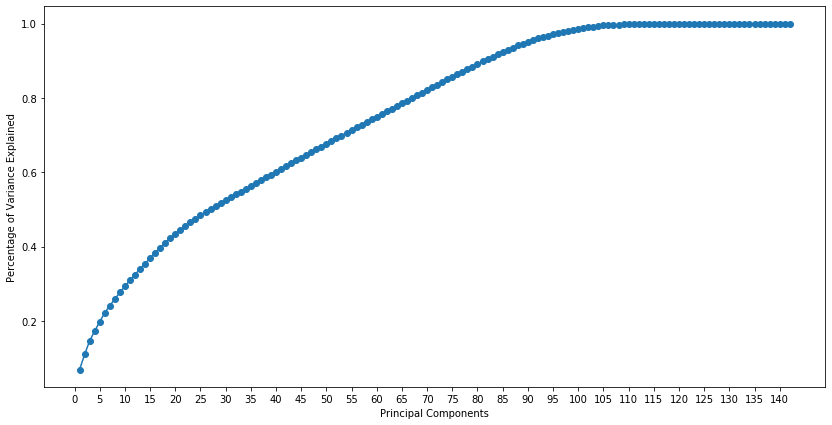

In [19]:
#Dimensionality Reduction using PCA
pca = PCA()
pca.fit(X_train_scaled)

plt.figure(figsize=(14,7))
plt.plot(range(1,143), pca.explained_variance_ratio_.cumsum(), marker = 'o')
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Variance Explained')
plt.xticks(range(0,142,5))
plt.show

Doing a PCA anlaysis, it seems as if 80% of the explained variance of our data can be explained between 65 to 70 Principal Components. With 90% of the variance is explained with 80 Principal Components. I will fit my data through 80 Principal components before doing the model. This will help us speed up the computational time.

In [25]:
pca = PCA(n_components = 80)
pca.fit(X_train_scaled)

#Transforming our data
X_train_PCA = pca.transform(X_train_scaled)
X_test_PCA = pca.transform(X_test_scaled)

In [26]:
# List of the various scoring metrics we will observe
validation_score_list = []
accuracy_score_train = []
accuracy_score_test = []
recall_list = []
precision_list = []
f1score_list = []
#c_range to figure out optimzied c-value
c_range = [.000001,.00001,.0001,0.001,0.01,0.1,1]

In [27]:
%%time
#Model Loop
count = 0

for c in c_range:
    
    #Instatiate model
    log_reg = LogisticRegression(C=c, n_jobs = -1)
    count += 1
    print(f'Model {count} instatiated.')
    
    #append validation score
    val_score = np.mean(cross_val_score(log_reg, X_train_PCA, y_train, cv = 5))
    validation_score_list.append(val_score)
    
    #Fitting the Model
    log_reg.fit(X_train_PCA, y_train)
    print(f'Model {count} fitted.')
    
    #Predict 
    pred_train = log_reg.predict(X_train_PCA)
    pred_test = log_reg.predict(X_test_PCA)
    print(f'Model {count} predicted.')
    
    #Append the Evaluation Metrics List
    accuracy_score_train.append(accuracy_score(y_train, pred_train))
    accuracy_score_test.append(accuracy_score(y_test, pred_test))
    
    recall_list.append(recall_score(y_test, pred_test))
    precision_list.append(precision_score(y_test, pred_test))
    f1score_list.append(f1_score(y_test, pred_test))

Model 1 instatiated.
Model 1 fitted.
Model 1 predicted.
Model 2 instatiated.
Model 2 fitted.
Model 2 predicted.
Model 3 instatiated.
Model 3 fitted.
Model 3 predicted.
Model 4 instatiated.
Model 4 fitted.
Model 4 predicted.
Model 5 instatiated.
Model 5 fitted.
Model 5 predicted.
Model 6 instatiated.
Model 6 fitted.
Model 6 predicted.
Model 7 instatiated.
Model 7 fitted.
Model 7 predicted.
CPU times: user 19.2 s, sys: 2.13 s, total: 21.3 s
Wall time: 2min 11s


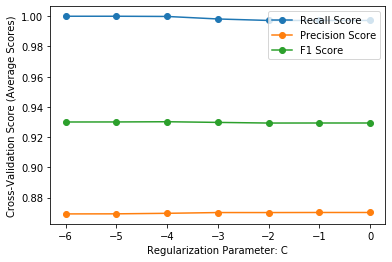

In [28]:
%matplotlib inline
plt.figure()
plt.plot(np.log10(c_range), recall_list,label="Recall Score",marker='o')
plt.plot(np.log10(c_range), precision_list,label="Precision Score",marker='o')
plt.plot(np.log10(c_range), f1score_list,label="F1 Score",marker='o')
plt.legend()
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross-Validation Score (Average Scores)')
plt.show();

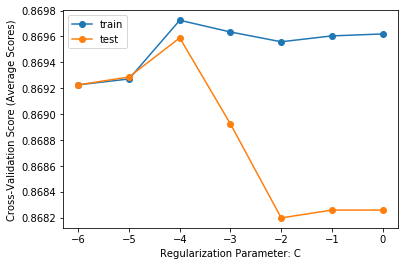

In [29]:
plt.figure()
plt.plot(np.log10(c_range), accuracy_score_train,label="train",marker='o')
plt.plot(np.log10(c_range), accuracy_score_test,label="test",marker='o')
plt.legend()
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross-Validation Score (Average Scores)')
plt.show();

# Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
# List of the various scoring metrics we will observe
validation_score_list_dt = []
accuracy_score_train_dt = []
accuracy_score_test_dt = []
recall_list_dt = []
precision_list_dt = []
f1score_list_dt = []

#Decision Tree Depth Range
depth_range = np.arange(1,50,5)

In [34]:
%%time
#Model Loop
count = 0

for i in depth_range:
    # Lets plot out different parameters with 5-fold cross validation


    # Instantiate
    dt = DecisionTreeClassifier(max_depth = i)
    count += 1
    print(f'Model {count} instatiated.')

    val_score = np.mean(cross_val_score(dt, X_train_PCA, y_train, cv = 5))
    validation_score_list.append(val_score)
    
    # Fit
    dt.fit(X_train_PCA, y_train)
    print(f'Model {count} fitted.')

    # predict
    pred_train = dt.predict(X_train_PCA)
    pred_test = dt.predict(X_test_PCA)
    print(f'Model {count} predicted.')
    
    #Append the Evaluation Metrics List
    accuracy_score_train_dt.append(accuracy_score(y_train, pred_train))
    accuracy_score_test_dt.append(accuracy_score(y_test, pred_test))
    recall_list_dt.append(recall_score(y_test, pred_test))
    precision_list_dt.append(precision_score(y_test, pred_test))
    f1score_list_dt.append(f1_score(y_test, pred_test))

Model 1 instatiated.
Model 1 fitted.
Model 1 predicted.
Model 2 instatiated.
Model 2 fitted.
Model 2 predicted.
Model 3 instatiated.
Model 3 fitted.
Model 3 predicted.
Model 4 instatiated.
Model 4 fitted.
Model 4 predicted.
Model 5 instatiated.
Model 5 fitted.
Model 5 predicted.
Model 6 instatiated.
Model 6 fitted.
Model 6 predicted.
Model 7 instatiated.
Model 7 fitted.
Model 7 predicted.
Model 8 instatiated.
Model 8 fitted.
Model 8 predicted.
Model 9 instatiated.
Model 9 fitted.
Model 9 predicted.
Model 10 instatiated.
Model 10 fitted.
Model 10 predicted.
CPU times: user 10min 11s, sys: 5.66 s, total: 10min 17s
Wall time: 10min 31s


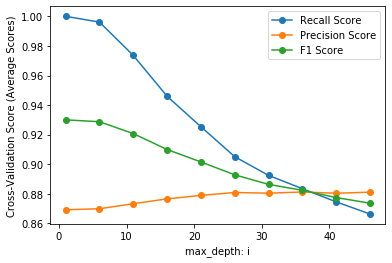

In [35]:
%matplotlib inline
plt.figure()
plt.plot(depth_range, recall_list_dt,label="Recall Score",marker='o')
plt.plot(depth_range, precision_list_dt,label="Precision Score",marker='o')
plt.plot(depth_range, f1score_list_dt,label="F1 Score",marker='o')
plt.legend()
plt.xlabel('max_depth: i')
plt.ylabel('Cross-Validation Score (Average Scores)')
plt.show();

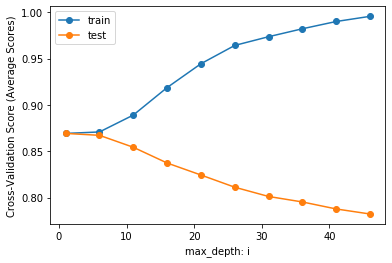

In [36]:
plt.figure()
plt.plot(depth_range, accuracy_score_train_dt,label="train",marker='o')
plt.plot(depth_range, accuracy_score_test_dt,label="test",marker='o')
plt.legend()
plt.xlabel('max_depth: i')
plt.ylabel('Cross-Validation Score (Average Scores)')
plt.show();

In [ ]:

def model_run_fit_pred_1_tuner(model_name, 
                               parameter_range, 
                               parameter_tuned,
                              X_train,X_test,y_train,y_test):
    
    count = 0
    
    # List of the various scoring metrics we will observe
    validation_score_list = []
    accuracy_score_train = []
    accuracy_score_test = []
    recall_list = []
    precision_list = []
    f1score_list = []
    
    for i in parameter_range:
        
        my_model = model_name(parameter_tuned = i)
        count += 1
        print(f'{str(model_name)} {count} instatied.')
        
        val_score = np.mean(cross_val_score(my_model, X_train, y_train, cv = 5))
        validation_sore_list.append(val_score)
        
        #Fiting 
        my_model.fit(X_train, y_train)
        print(f'{str(model_name)} {count} fitted')
        
        #Predict
        pred_train = my_model.fit(X_train)
        pred_test = my_model.fit(X_test)
        print(f'{str(model_name)} {count} predicted.')
        
        #Append the Evaluation Metrics List
        accuracy_score_train.append(accuracy_score(y_train, pred_train))
        accuracy_score_test.append(accuracy_score(y_test, pred_test))
        recall_list.append(recall_score(y_test, pred_test))
        precision_list.append(precision_score(y_test, pred_test))
        f1score_list.append(f1_score(y_test, pred_test))
    
    
    return



for i in depth_range:
    # Lets plot out different parameters with 5-fold cross validation


    # Instantiate
    dt = DecisionTreeClassifier(max_depth = i)
    count += 1
    print(f'Model {count} instatiated.')

    val_score = np.mean(cross_val_score(dt, X_train_PCA, y_train, cv = 5))
    validation_score_list.append(val_score)
    
    # Fit
    dt.fit(X_train_PCA, y_train)
    print(f'Model {count} fitted.')

    # predict
    pred_train = dt.predict(X_train_PCA)
    pred_test = dt.predict(X_test_PCA)
    print(f'Model {count} predicted.')
    
    #Append the Evaluation Metrics List
    accuracy_score_train_dt.append(accuracy_score(y_train, pred_train))
    accuracy_score_test_dt.append(accuracy_score(y_test, pred_test))
    recall_list_dt.append(recall_score(y_test, pred_test))
    precision_list_dt.append(precision_score(y_test, pred_test))
    f1score_list_dt.append(f1_score(y_test, pred_test))